In [1]:
## Import libraries

In [2]:
library(ggplot2)
library(tidyr)
library(dplyr)
library(scales)
library(stringr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
# It is important to emphasize that some samples do not have timestamps because it is not provided 
# for 'scheduled' status. But, I dont know its reason.

In [4]:
df_log <- read.csv(file = 'events.csv', sep = ',', stringsAsFactors = FALSE)
df_log$creation_timestamp <- as.POSIXct(df_log$creation_timestamp,format='%Y-%m-%dT%H:%M:%SZ', tzone = "UTC")
df_log$timestamp <- as.numeric(df_log$creation_timestamp)
df_log$timestamp[is.na(df_log$timestamp)] <- Inf

df_log <- df_log %>% 
  distinct() %>%
  group_by(uid) %>%
  mutate(min_timestamp = min(timestamp)) %>%
  ungroup()
summary(df_log)

     uid                name           function_name     
 Length:125         Length:125         Length:125        
 Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character  
                                                         
                                                         
                                                         
 creation_timestamp            first_timestamp    last_timestamp    
 Min.   :2021-07-13 15:20:57   Length:125         Length:125        
 1st Qu.:2021-07-13 15:21:25   Class :character   Class :character  
 Median :2021-07-13 15:21:52   Mode  :character   Mode  :character  
 Mean   :2021-07-13 15:22:54                                        
 3rd Qu.:2021-07-13 15:24:05                                        
 Max.   :2021-07-13 15:37:22                                        
    reason              node             message            timestamp        
 Length:125         Length:125   

In [5]:
df_activations <- read.csv(file = 'activations.csv', sep = ',', stringsAsFactors = FALSE)
summary(df_activations)

  object_uid        object_name        function_name         duration        
 Length:77          Length:77          Length:77          Min.   :  0.00870  
 Class :character   Class :character   Class :character   1st Qu.:  0.08779  
 Mode  :character   Mode  :character   Mode  :character   Median :  0.70689  
                                                          Mean   : 13.93080  
                                                          3rd Qu.:  6.46312  
                                                          Max.   :180.67434  
                                                          NA's   :42         
   timestamp            reason            node         message       
 Min.   :1.626e+09   Length:77          Mode:logical   Mode:logical  
 1st Qu.:1.626e+09   Class :character   NA's:77        NA's:77       
 Median :1.626e+09   Mode  :character                                
 Mean   :1.626e+09                                                   
 3rd Qu.:1.626e+09        

In [6]:
####################################

In [7]:
# Duration analysis

In [8]:
####################################

In [9]:
### Filter the events file

In [10]:
df_filtered <- df_log %>%
    filter(
      #reason == 'Scheduled' |
      reason == 'Pulling' |
      reason == 'Pulled' |
      reason == 'Created' |
      reason == 'Started' )#|
      #reason == 'Killing') %>%

df_selected <- df_filtered %>%
    mutate(duration = abs(timestamp - min_timestamp)) %>%
    select(-name, -uid, -message, -min_timestamp, -creation_timestamp, -first_timestamp, -last_timestamp, -timestamp)
summary(df_selected)

 function_name         reason              node              duration    
 Length:82          Length:82          Length:82          Min.   : 1.00  
 Class :character   Class :character   Class :character   1st Qu.: 6.00  
 Mode  :character   Mode  :character   Mode  :character   Median :12.50  
                                                          Mean   :16.90  
                                                          3rd Qu.:25.25  
                                                          Max.   :57.00  

In [11]:
### Process the events durations

In [12]:
df_spread <- df_selected %>%
    group_by_at(vars(-duration)) %>%
    mutate(sample_id = row_number()) %>% ungroup() %>%
    spread(reason, duration) %>%
    select(-sample_id)
print(df_spread)

df_processed <- df_spread %>%
    group_by(function_name) %>%
    mutate(
        #container_scheduling = abs(Scheduled - Pulling),
        container_image_downloading = abs(Pulled - Pulling),
        container_image_creation = abs(Created - Pulled),
        container_initialization = abs(Started - Created)) %>%#,
        #container_removal = abs(Killing - Started)) %>%
    select(
        function_name,
        node,
        #container_scheduling,
        container_image_downloading,
        container_image_creation,
        container_initialization)#,
        #container_removal)
head(df_processed)

# A tibble: 21 x 6
   function_name    node                          Created Pulled Pulling Started
   <chr>            <chr>                           <dbl>  <dbl>   <dbl>   <dbl>
 1 chameleon1       paravance-17.rennes.grid5000…      29     28       1      29
 2 facedetection1   paravance-10.rennes.grid5000…      20     18      13      20
 3 facedetection2   paravance-18.rennes.grid5000…       7      5       1       7
 4 facedetection3   paravance-10.rennes.grid5000…      20     18      13      20
 5 floatoperation1  paravance-10.rennes.grid5000…      18     12       2      19
 6 floatoperation2  paravance-19.rennes.grid5000…      17     12       2      18
 7 floatoperation3  paravance-17.rennes.grid5000…      16     11       1      17
 8 imageprocessing1 paravance-18.rennes.grid5000…      56     39      18      56
 9 imageprocessing2 paravance-17.rennes.grid5000…      57     53      46      57
10 linpack1         paravance-17.rennes.grid5000…      27     23       1      28
# … with 

function_name   node                            container_image_downloading
1 chameleon1      paravance-17.rennes.grid5000.fr 27                         
2 facedetection1  paravance-10.rennes.grid5000.fr  5                         
3 facedetection2  paravance-18.rennes.grid5000.fr  4                         
4 facedetection3  paravance-10.rennes.grid5000.fr  5                         
5 floatoperation1 paravance-10.rennes.grid5000.fr 10                         
6 floatoperation2 paravance-19.rennes.grid5000.fr 10                         
  container_image_creation container_initialization
1 1                        0                       
2 2                        0                       
3 2                        0                       
4 2                        0                       
5 6                        1                       
6 5                        1

In [13]:
### Filter the activations file

In [14]:
df_activations_selected <- df_activations %>%
    select(
        function_name,
        duration,
        reason,
        node,
        object_uid) #%>%
        #mutate(duration = (duration / 1000) %% 60)
summary(df_activations_selected)

 function_name         duration            reason            node        
 Length:77          Min.   :  0.00870   Length:77          Mode:logical  
 Class :character   1st Qu.:  0.08779   Class :character   NA's:77       
 Mode  :character   Median :  0.70689   Mode  :character                 
                    Mean   : 13.93080                                    
                    3rd Qu.:  6.46312                                    
                    Max.   :180.67434                                    
                    NA's   :42                                           
  object_uid       
 Length:77         
 Class :character  
 Mode  :character  
                   
                   
                   
                   

In [15]:
### First view of activations

'data.frame':	77 obs. of  5 variables:
 $ function_name: chr  "rnngenerate3" "rnngenerate3" "rnngenerate3" "rnngenerate3" ...
 $ duration     : num  0.0274 0.0203 NA NA 0.0247 ...
 $ reason       : chr  "download_data" "function_execution" "finishing_time" "starting_time" ...
 $ node         : logi  NA NA NA NA NA NA ...
 $ object_uid   : chr  "8e03a80ab46f4e1883a80ab46f5e187d" "8e03a80ab46f4e1883a80ab46f5e187d" "8e03a80ab46f4e1883a80ab46f5e187d" "8e03a80ab46f4e1883a80ab46f5e187d" ...


Saving 6.67 x 6.67 in image

Warning message:
“Removed 42 rows containing missing values (position_stack).”
Warning message:
“Removed 42 rows containing missing values (position_stack).”
Saving 6.67 x 6.67 in image

Warning message:
“Removed 42 rows containing missing values (geom_point).”
Warning message:
“Removed 42 rows containing missing values (geom_point).”


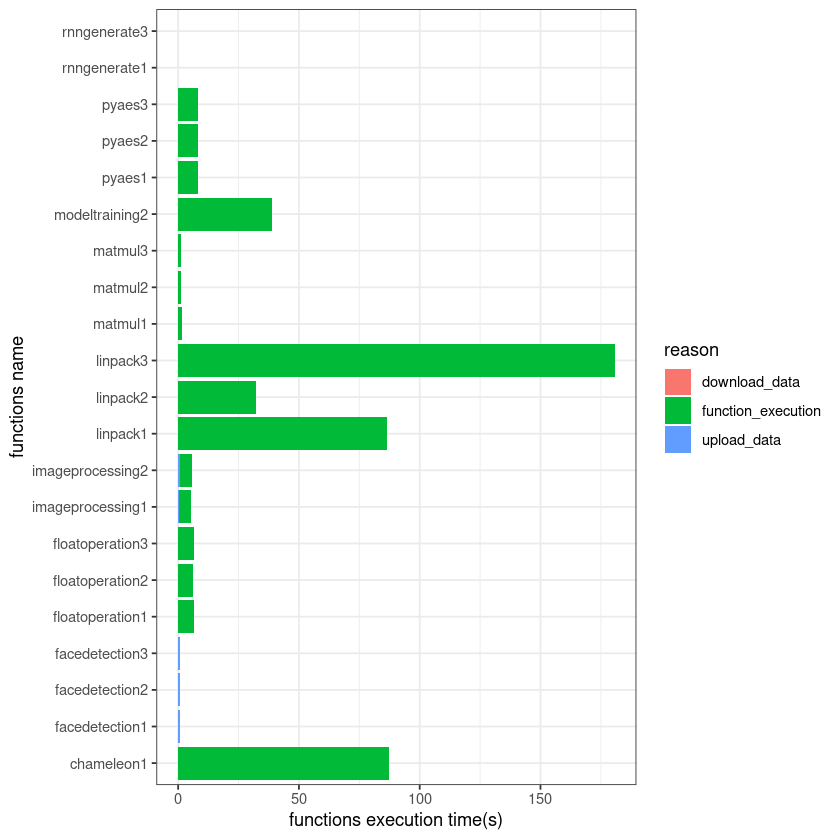

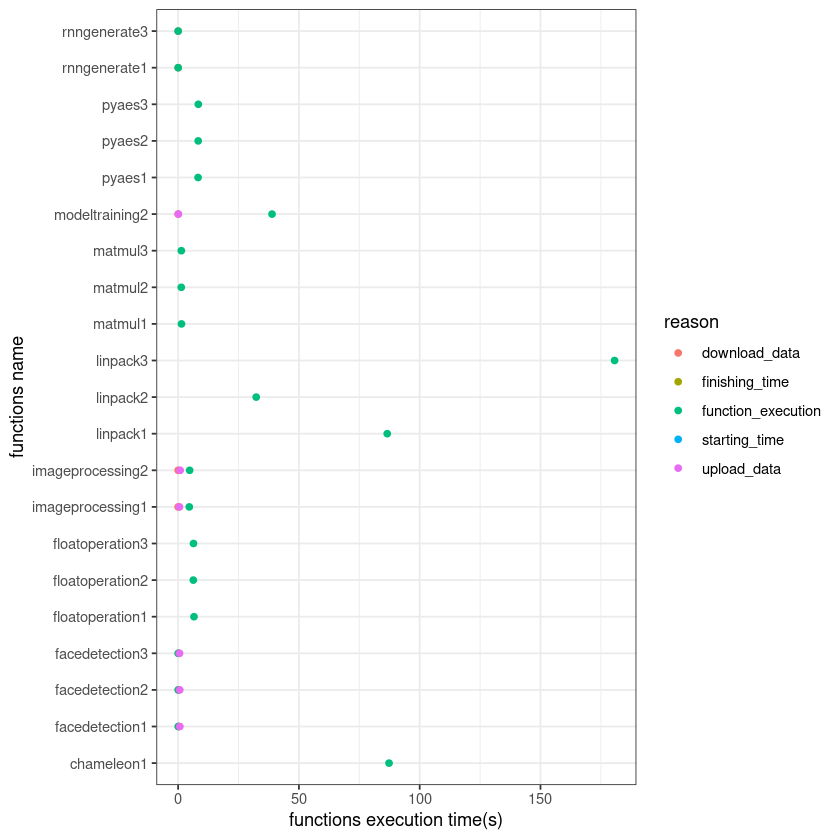

In [16]:
str(df_activations_selected)
df_plot <- df_activations_selected

ggplot(data = df_plot) +
   geom_bar(aes(x = duration, y = function_name, fill = reason),stat='identity')  +
   labs(x = "functions execution time(s)", y = "functions name") +
   theme_bw() +
   ggsave('activations_bar_plot.png')

ggplot(data = df_plot) +
   geom_point(aes(x = duration, y = function_name, color = reason),stat='identity')  +
   labs(x = "functions execution time(s)", y = "functions name") +
   theme_bw() +
   ggsave('activations_point_plot.png')

In [17]:
### Spread the timestamps of activations by categories

In [18]:
df_spread_activations <- df_activations_selected %>%
   group_by_at(vars(-duration)) %>%
   mutate(sample_id = row_number()) %>% ungroup() %>%
   spread(reason, duration) %>%
   select(-sample_id, -node, -object_uid)

head(df_spread_activations)
tail(df_spread_activations)

function_name   download_data finishing_time function_execution starting_time
1 chameleon1              NA    NA             87.31614971        NA           
2 facedetection1  0.10762954    NA              0.10762954        NA           
3 facedetection2  0.08880568    NA              0.08880568        NA           
4 facedetection3  0.08677340    NA              0.08677340        NA           
5 floatoperation1         NA    NA              6.56377673        NA           
6 floatoperation2         NA    NA              6.29889035        NA           
  upload_data
1        NA  
2 0.7068911  
3 0.6731298  
4 0.5942886  
5        NA  
6        NA

function_name  download_data finishing_time function_execution starting_time
1 modeltraining2 0.008696556   NA             38.87911415        NA           
2 pyaes1                  NA   NA              8.26116490        NA           
3 pyaes2                  NA   NA              8.31664109        NA           
4 pyaes3                  NA   NA              8.36406565        NA           
5 rnngenerate1   0.024744749   NA              0.02571630        NA           
6 rnngenerate3   0.027426243   NA              0.02030396        NA           
  upload_data
1 0.1094401  
2        NA  
3        NA  
4        NA  
5        NA  
6        NA

In [19]:
### Merge the activations and events data

In [20]:
# That occurs some error with imageprocessing2 from Kubernetes side, it was not registered its node.
#df_spread_activations <- df_spread_activations %>% filter(function_name != 'imageprocessing2')

In [21]:
df_events_to_join <- df_processed #%>% mutate(id = row_number())
head(df_events_to_join)
df_activations_to_join <- df_spread_activations #%>% mutate(id = row_number())
head(df_activations_to_join)

df_all <- full_join(
   df_events_to_join,
   df_activations_to_join,
   by="function_name") %>%
   distinct()
#df_all[is.na(df_all)] = 0

summary(df_all)

function_name   node                            container_image_downloading
1 chameleon1      paravance-17.rennes.grid5000.fr 27                         
2 facedetection1  paravance-10.rennes.grid5000.fr  5                         
3 facedetection2  paravance-18.rennes.grid5000.fr  4                         
4 facedetection3  paravance-10.rennes.grid5000.fr  5                         
5 floatoperation1 paravance-10.rennes.grid5000.fr 10                         
6 floatoperation2 paravance-19.rennes.grid5000.fr 10                         
  container_image_creation container_initialization
1 1                        0                       
2 2                        0                       
3 2                        0                       
4 2                        0                       
5 6                        1                       
6 5                        1

function_name   download_data finishing_time function_execution starting_time
1 chameleon1              NA    NA             87.31614971        NA           
2 facedetection1  0.10762954    NA              0.10762954        NA           
3 facedetection2  0.08880568    NA              0.08880568        NA           
4 facedetection3  0.08677340    NA              0.08677340        NA           
5 floatoperation1         NA    NA              6.56377673        NA           
6 floatoperation2         NA    NA              6.29889035        NA           
  upload_data
1        NA  
2 0.7068911  
3 0.6731298  
4 0.5942886  
5        NA  
6        NA

 function_name          node           container_image_downloading
 Length:21          Length:21          Min.   : 2                 
 Class :character   Class :character   1st Qu.: 5                 
 Mode  :character   Mode  :character   Median :10                 
                                       Mean   :11                 
                                       3rd Qu.:16                 
                                       Max.   :27                 
                                       NA's   :2                  
 container_image_creation container_initialization download_data     
 Min.   : 0.000           Min.   :0.0000           Min.   :0.008697  
 1st Qu.: 2.000           1st Qu.:0.0000           1st Qu.:0.022707  
 Median : 2.000           Median :0.0000           Median :0.026085  
 Mean   : 3.476           Mean   :0.3333           Mean   :0.048342  
 3rd Qu.: 4.000           3rd Qu.:1.0000           3rd Qu.:0.087281  
 Max.   :17.000           Max.   :1.0000    

In [22]:
df_gathered <- df_all %>%
    gather(
        factor_key = 'TRUE',
        key = 'reason',
        value = 'duration',
        -function_name, -node) %>%
    drop_na()
df_gathered$reason <- str_replace_all(df_gathered$reason, 'container_image_downloading', '00_container_image_downloading')
df_gathered$reason <- str_replace_all(df_gathered$reason, 'container_image_creation', '01_container_image_creation')
df_gathered$reason <- str_replace_all(df_gathered$reason, 'container_initialization', '02_container_initialization')
df_gathered$reason <- str_replace_all(df_gathered$reason, 'download_data', '03_download_data')
df_gathered$reason <- str_replace_all(df_gathered$reason, 'function_execution', '04_function_execution')
df_gathered$reason <- str_replace_all(df_gathered$reason, 'upload_data', '05_upload_data')

df_plot <- df_gathered
summary(df_plot)
head(df_plot)
tail(df_plot)

 function_name          node              reason             duration       
 Length:96          Length:96          Length:96          Min.   :  0.0000  
 Class :character   Class :character   Class :character   1st Qu.:  0.0883  
 Mode  :character   Mode  :character   Mode  :character   Median :  1.6989  
                                                          Mean   :  8.0894  
                                                          3rd Qu.:  5.2500  
                                                          Max.   :180.6743  

function_name   node                           
1 chameleon1      paravance-17.rennes.grid5000.fr
2 facedetection1  paravance-10.rennes.grid5000.fr
3 facedetection2  paravance-18.rennes.grid5000.fr
4 facedetection3  paravance-10.rennes.grid5000.fr
5 floatoperation1 paravance-10.rennes.grid5000.fr
6 floatoperation2 paravance-19.rennes.grid5000.fr
  reason                         duration
1 00_container_image_downloading 27      
2 00_container_image_downloading  5      
3 00_container_image_downloading  4      
4 00_container_image_downloading  5      
5 00_container_image_downloading 10      
6 00_container_image_downloading 10

function_name    node                            reason         duration 
1 facedetection1   paravance-10.rennes.grid5000.fr 05_upload_data 0.7068911
2 facedetection2   paravance-18.rennes.grid5000.fr 05_upload_data 0.6731298
3 facedetection3   paravance-10.rennes.grid5000.fr 05_upload_data 0.5942886
4 imageprocessing1 paravance-18.rennes.grid5000.fr 05_upload_data 0.5611203
5 imageprocessing2 paravance-17.rennes.grid5000.fr 05_upload_data 0.8477736
6 modeltraining2   paravance-17.rennes.grid5000.fr 05_upload_data 0.1094401

In [23]:
a <- df_plot %>% filter(function_name == 'linpack3')
print(a)

# A tibble: 4 x 4
# Groups:   function_name [1]
  function_name node                         reason                     duration
  <chr>         <chr>                        <chr>                         <dbl>
1 linpack3      paravance-19.rennes.grid500… 00_container_image_downlo…      24 
2 linpack3      paravance-19.rennes.grid500… 01_container_image_creati…       4 
3 linpack3      paravance-19.rennes.grid500… 02_container_initializati…       0 
4 linpack3      paravance-19.rennes.grid500… 04_function_execution          181.


In [24]:
### Plot the merged data

Saving 6.67 x 6.67 in image



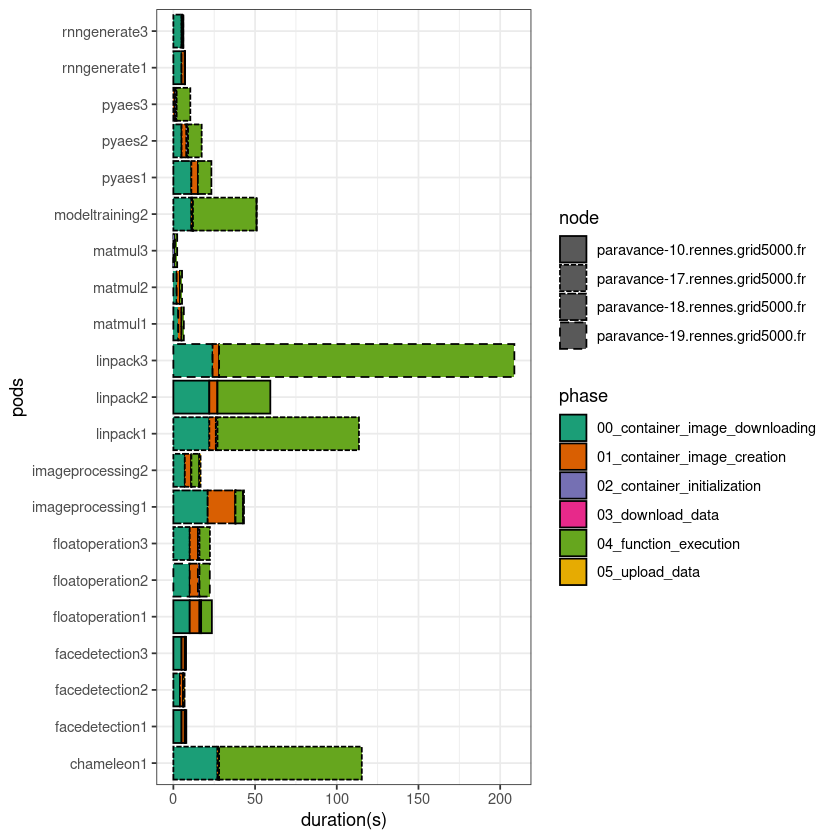

In [25]:
ggplot(data = df_plot, aes(x = duration, y = function_name, fill = reason, linetype = node))+#, color = node)) +
   geom_bar(stat='identity', position = position_stack(reverse = TRUE), color = "black")  +
   labs(x = "duration(s)", y = "pods", fill = "phase") +
   scale_fill_brewer(palette = "Dark2") +
   theme_bw() +
   ggsave('full_bar_plot_stack.png')

Saving 6.67 x 6.67 in image



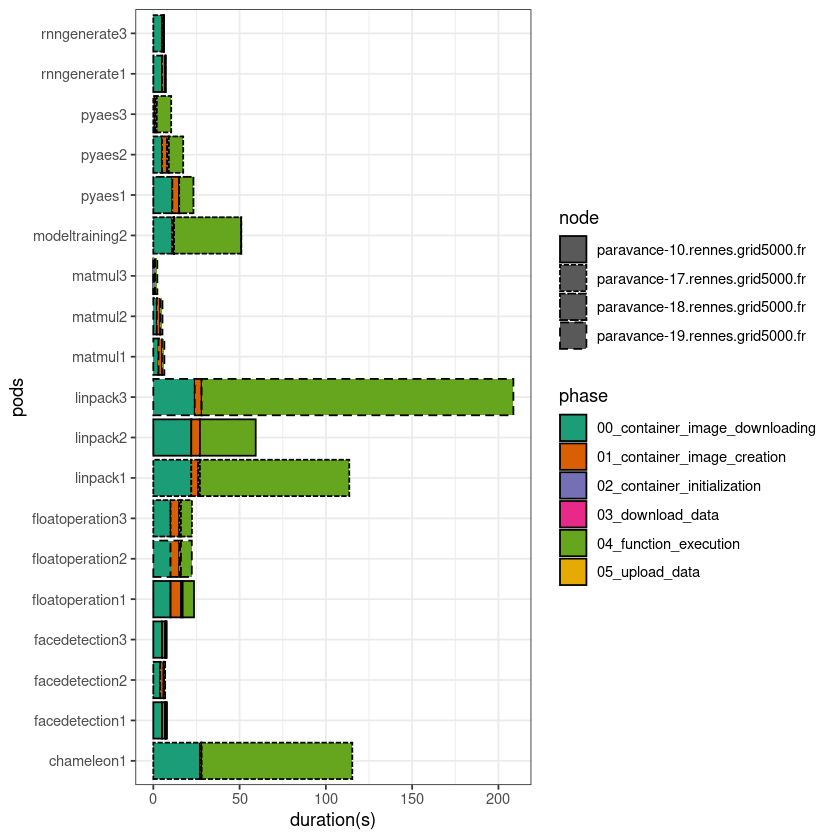

In [26]:
df_plot2 <- df_plot %>% filter(function_name != 'videoprocessing1' & function_name != 'videoprocessing2' & function_name != 'videoprocessing3' &
                              function_name != 'imageprocessing1' & function_name != 'imageprocessing2' & function_name != 'imageprocessing3')

ggplot(data = df_plot2, aes(x = duration, y = function_name, fill = reason, linetype = node))+#, color = node)) +
   geom_bar(stat='identity', position = position_stack(reverse = TRUE), color = "black")  +
   labs(x = "duration(s)", y = "pods", fill = "phase") +
   scale_fill_brewer(palette = "Dark2") +
   theme_bw() +
   ggsave('full_bar_plot_stack_filtered.png')

Saving 6.67 x 6.67 in image



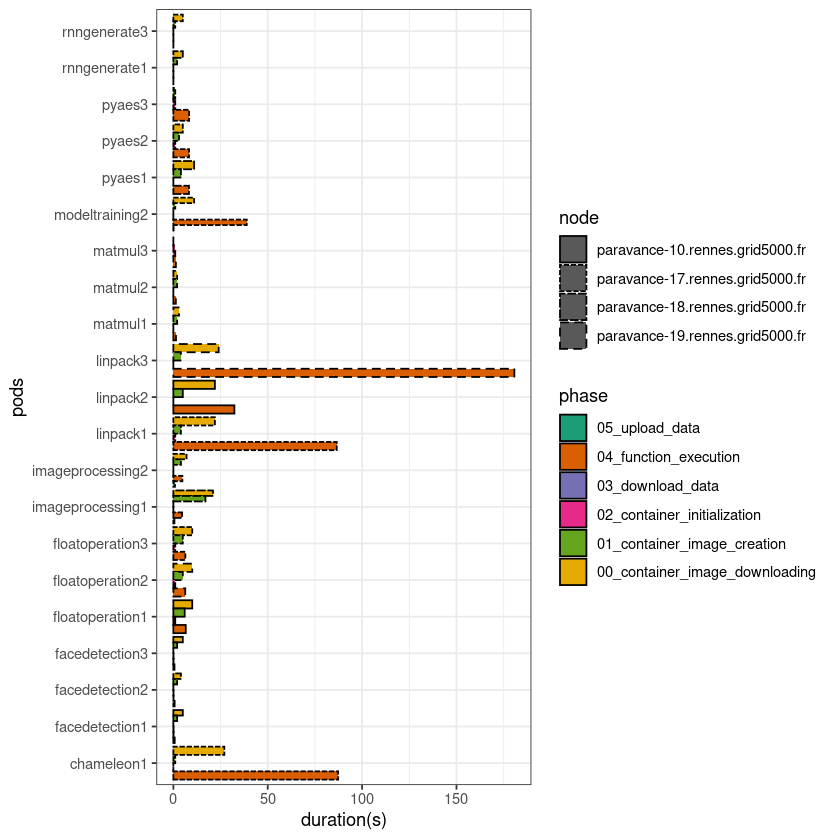

In [27]:
ggplot(data = df_plot, aes(x = duration, y = function_name, linetype = node,
                           fill = factor(reason, levels = rev(c("00_container_image_downloading",
                                  "01_container_image_creation", 
                                  "02_container_initialization", 
                                  "03_download_data", 
                                  "04_function_execution", 
                                  "05_upload_data"))))) +#, color = node)) +
   geom_bar(position="dodge", stat='identity', color = "black")  +
   labs(x = "duration(s)", y = "pods", fill = "phase") +
   theme_bw() +
   scale_fill_brewer(palette = "Dark2") +
   #guides(fill = guide_legend(reverse = TRUE))
   ggsave('full_bar_plot_dodge.png')

Saving 6.67 x 6.67 in image

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 15 rows containing missing values (geom_bar).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 15 rows containing missing values (geom_bar).”


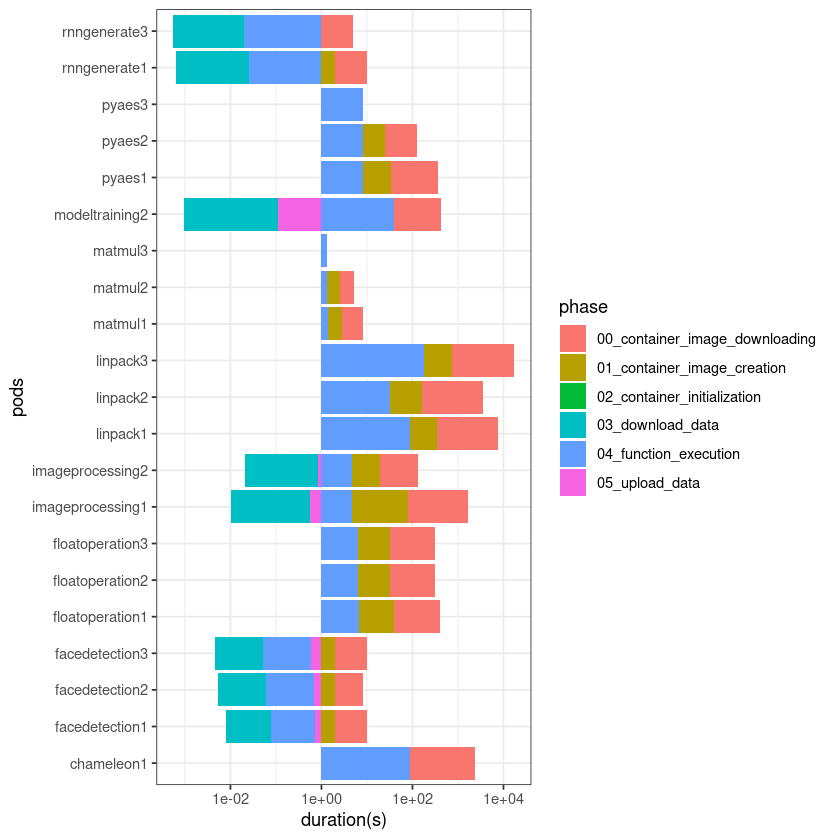

In [28]:
ggplot(data = df_plot, aes(x = duration, y = function_name, fill = reason))+#, color = node)) +
   geom_bar(stat='identity')  +
    scale_x_log10() +
   labs(x = "duration(s)", y = "pods", fill = "phase") +
   theme_bw() +
   ggsave('full_bar_plot_log10.png')

Saving 6.67 x 6.67 in image



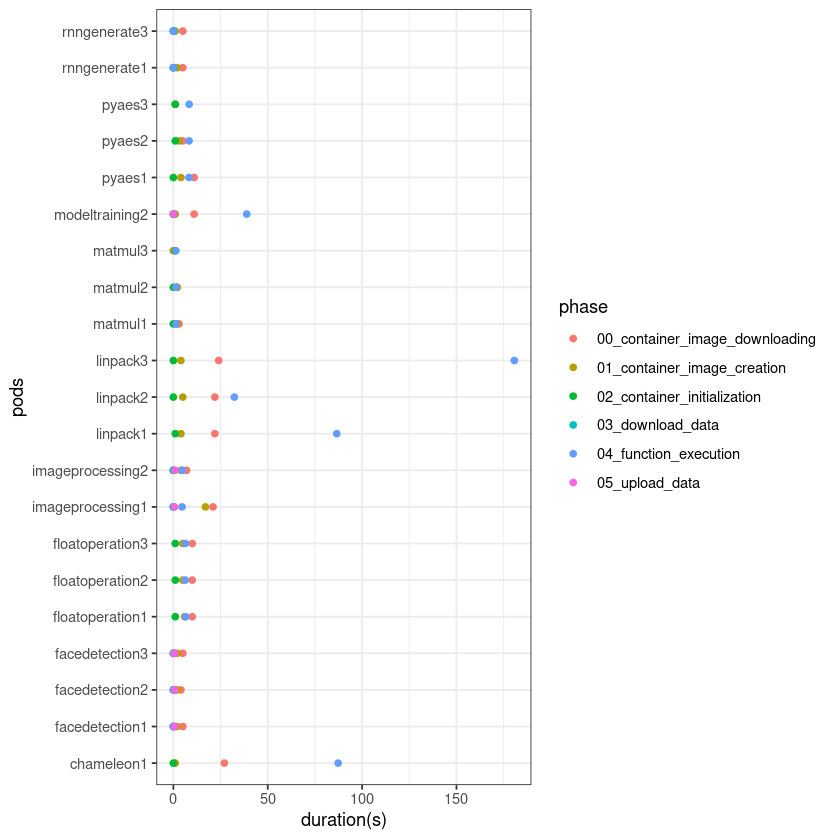

In [29]:
ggplot() +
    geom_point(data = df_plot, aes(x = duration, y = function_name, color = reason))+#, color = reason)) +
    labs(x = "duration(s)", y = "pods", color = "phase") +
    theme_bw() +
    ggsave('full_geom_point.png')

Saving 6.67 x 6.67 in image

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”


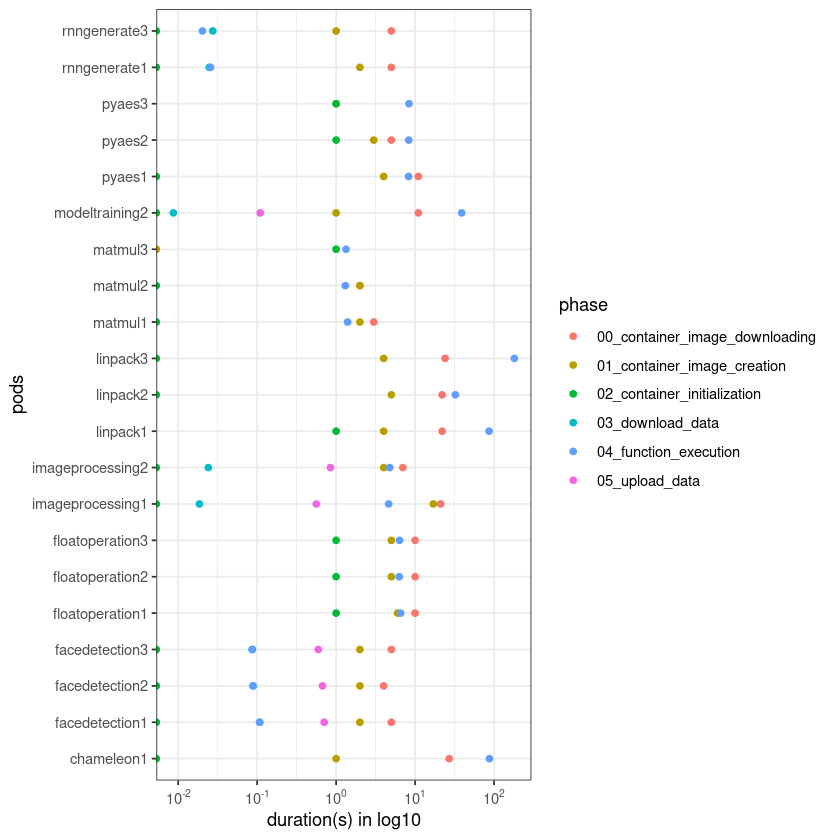

In [30]:
ggplot() +
    geom_point(data = df_plot, aes(x = duration, y = function_name, color = reason))+#, color = reason)) +
    labs(x = "duration(s) in log10", y = "pods", color = "phase") +
    scale_x_log10(breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))) +
    theme_bw() +
    ggsave('full_geom_point_log10.png')